# Next time: try and remove 'nan' stars from consideration, or add the nice ones to a new array
### Might need to move the 'attitude detection' section in front of aperture photometry cell, so just don't do ap photom on the bad ones?
# Also calculate apparent mag of a star? (see Luke's thing)
# Also change name of 'final_data' maybe? gets a bit confusing

# Attempting some basic aperture photometry (yeet)

Based on method used in previous source detection test

First up, dependencies:

In [102]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.table import Table
from astropy.table import Column
from photutils import DAOStarFinder
from photutils import CircularAperture, CircularAnnulus
from photutils import aperture_photometry
from matplotlib.colors import LogNorm
#from astropy.visualization import SqrtStretch
#from astropy.visualization.mpl_normalize import ImageNormalize

Importing .fits file and extracting the ~ *data* ~:

In [103]:
image_file = 'example_data/PAL5_3p6um.fits'
image_data = fits.getdata(image_file, ext=0)
#print(image_data.shape)

hdu_list = fits.open(image_file)
hdr = hdu_list[0].header
#data = hdu_list[0].data   # could open data here instead of fits.getdata above, more consistent
gain = hdr['GAIN']         # don't need gain any more
exptime = hdr['EXPTIME']
fluxconv = hdr['FLUXCONV']
print(gain, exptime, fluxconv)
hdu_list.close()

data = image_data * exptime / fluxconv

3.71 969.101928711 0.1469


Locating the objects in the image using DAOStarFinder, and plotting no. of stars detected vs. sigma curve:

In [104]:
#def detect_sources(data, sigma_level, FWHM):
#    daofind = DAOStarFinder(threshold = sigma_level * std, fwhm=FWHM)
#    sources = daofind(data - median)
#    return sources

In [105]:
mean, median, std = sigma_clipped_stats(data, sigma=4.) # don't need mean any more?

#detect_sources(data, sigma_level=5., FWHM=3.)
#for col in sources.colnames:
#    sources[col].info.format = '%.8g'
#print(sources)

#for i in range(1, 8):
#    detect_sources(data, sigma_level=float(i), FWHM=3.)
#    print(len(sources))

no_detected = []
sigma_vals = []
 
#for i in np.arange(1., 15.5, 0.5):
#    #print(i)
#    daofind = DAOStarFinder(threshold = i * std, fwhm = 3.)
#    sources = daofind(data - median)
#    #print(len(sources))
#    
#    no_detected.append(len(sources))
#    sigma_vals.append(i)
#
#print(no_detected)
#print(sigma_vals)

In [106]:
#plt.plot(sigma_vals, no_detected)
#plt.xlabel('sigma')
#plt.ylabel('number of sources detected')
#plt.grid(True)
#plt.savefig('images/sigma_curve_01.png', dpi=100)

Adding the centroid positions of the objects to an array and fitting circular apertures and annuli around them:

C:\Users\Jake\anaconda3\lib\site-packages\matplotlib\colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


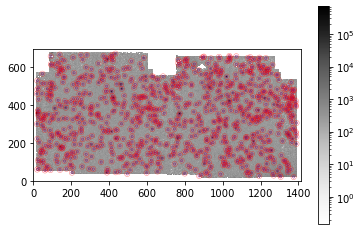

In [107]:
daofind = DAOStarFinder(threshold = 4. * std, fwhm = 3.)  # 4 sigma seems ideal to me
sources = daofind(data - median)

pos = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(pos, r=6.)
annuli = CircularAnnulus(pos, r_in=6., r_out=14.)
all_apers = [apertures, annuli]
norm = LogNorm()
plt.imshow(data, cmap='Greys', origin='lower', norm=norm, interpolation='nearest')
plt.colorbar()
apertures.plot(color='blue', lw=.5, alpha=.5)
annuli.plot(color='red', lw=.5, alpha=.5)

#plt.title('4 sigma')
#plt.savefig('images/sigma_4.png', dpi=500)

Performing some basic aperture photometry, summing the pixel brightness values (fluxes?) inside each aperture and annulus:

(Note: 'nan' values for apertures could be where the objects are too close to the edge of the image and use some pure white in their summation, and those for the annuli might be where annuli overlap?)

In [108]:
phot_table = aperture_photometry(data, all_apers)
for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'
print(phot_table)

 id  xcenter   ycenter  aperture_sum_0 aperture_sum_1
       pix       pix                                 
--- --------- --------- -------------- --------------
  1  1374.715  21.00836            nan            nan
  2 1306.2872 21.691519            nan            nan
  3 1193.3978 26.582374      40170.307            nan
  4  875.5912 26.690492            nan            nan
  5 1269.2458 28.561557      92495.088            nan
  6 929.15178 29.723225      37404.056            nan
  7 1140.0222 29.913012      68417.435            nan
  8 1302.2448 30.489824      157632.94            nan
  9 890.49164 34.446212      36457.077      158338.43
 10 989.51277 35.887709      45001.038       159571.9
...       ...       ...            ...            ...
989 1071.7977 658.65453            nan            nan
990 91.637048 658.52925            nan            nan
991 1035.1634 660.07166            nan            nan
992 370.50076 660.02253      64689.982      180624.47
993 409.61314 662.66578     

Finding which star coordinates are giving me attitude and plotting them:

923
75 [1, 2, 3, 4, 5, 6, 7, 8, 11, 12, 17, 18, 19, 20, 25, 30, 32, 36, 38, 41, 43, 47, 92, 109, 237, 276, 300, 326, 335, 361, 385, 388, 394, 460, 486, 504, 519, 533, 569, 577, 601, 617, 635, 698, 734, 747, 816, 824, 842, 847, 850, 851, 870, 900, 933, 934, 943, 948, 951, 961, 975, 977, 978, 981, 982, 984, 985, 986, 987, 988, 989, 990, 991, 997, 998]


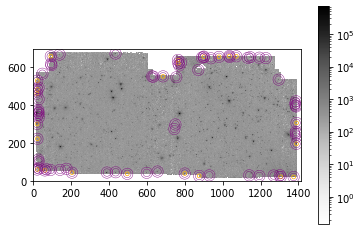

In [109]:
fail_test_x_ap = []
fail_test_y_ap = []
fail_test_x_an = []
fail_test_y_an = []
fail_test_id = []
nice_data = []

# could instead do annulus first, then 'elif' aperture
for i in range(0, len(phot_table)):
    if np.isnan(phot_table['aperture_sum_0'][i]) == True:
        fail_test_x_ap.append(phot_table['xcenter'][i].value)
        fail_test_y_ap.append(phot_table['ycenter'][i].value)
    if np.isnan(phot_table['aperture_sum_1'][i]) == True:
        fail_test_x_an.append(phot_table['xcenter'][i].value)
        fail_test_y_an.append(phot_table['ycenter'][i].value)
        fail_test_id.append(phot_table['id'][i])
    else:
        nice_data.append(phot_table[:][i])

fail_test_all_ap = np.column_stack((fail_test_x_ap, fail_test_y_ap))
fail_test_all_an = np.column_stack((fail_test_x_an, fail_test_y_an))
aperture_fails = CircularAperture(fail_test_all_ap, r=10.)
annulus_fails = CircularAnnulus(fail_test_all_an, r_in=20., r_out=30.)
#print(len(aperture_fails), len(annulus_fails))

#print(fail_test_all_ap)
#print(fail_test_all_an)
print(len(nice_data))
print(len(fail_test_id), fail_test_id)

plt.imshow(data, cmap='Greys', origin='lower', norm=norm, interpolation='nearest')
plt.colorbar()
aperture_fails.plot(color='orange', lw=.7, alpha=1.)
annulus_fails.plot(color='purple', lw=.4, alpha=1.)

#plt.savefig('images/ap_photom_fail_stars_04.png', dpi=500)

'nanmask' method creates a table of true/false values depending on which stars give me nans, and yeets them out of the data (~ operator inverts true -> false and vice-versa):

In [110]:
nanmask_ap = ~np.isnan(phot_table['aperture_sum_0'])
nanmask_an = ~np.isnan(phot_table['aperture_sum_1'])
final_data = phot_table[nanmask_an] # all nans in central apertures will also be present in the annuli, so can just base 
                                    # our data on the annuli masks (though implementing a check for both would be ideal)
print(final_data)

 id  xcenter   ycenter  aperture_sum_0 aperture_sum_1
       pix       pix                                 
--- --------- --------- -------------- --------------
  9 890.49164 34.446212      36457.077      158338.43
 10 989.51277 35.887709      45001.038       159571.9
 13 1125.1278 38.511314       50625.07      209814.28
 14 1263.9513 40.479416      74032.225      281246.65
 15 912.11758 40.450665      48776.473      151435.08
 16  1151.819 42.288902      218773.09      222422.43
 21 1344.7003 46.585935      251993.95      343926.73
 22 914.97724  46.86576      49451.747      164841.41
 23 1129.2009 48.586034      90700.981      217826.05
 24  452.8171 49.607009      56618.904      169802.85
...       ...       ...            ...            ...
974  1039.562 647.04899      76430.899      384773.11
976 383.48556  649.2791      84863.446      1665107.6
979 411.18347 651.02694      52480.335      228327.55
980 583.32007 649.84535      254842.65      160617.02
983 209.79374 652.59741     

Re-doing the aperture fittings ignoring the problem stars:

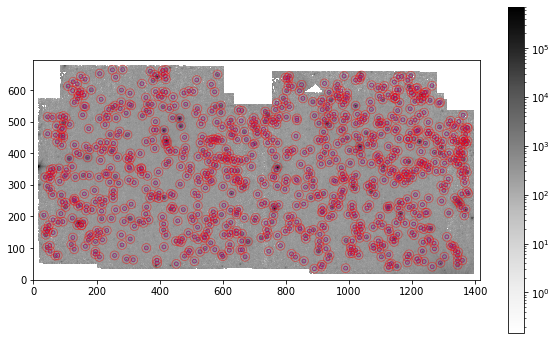

In [111]:
final_pos = np.transpose((final_data['xcenter'].value, final_data['ycenter'].value))
final_apertures = CircularAperture(final_pos, r=6.)
final_annuli = CircularAnnulus(final_pos, r_in=6., r_out=14.)
final_all_apers = [final_apertures, final_annuli]

plt.imshow(data, cmap='Greys', origin='lower', norm=norm, interpolation='nearest')
plt.colorbar()
final_apertures.plot(color='blue', lw=.75, alpha=.5)
final_annuli.plot(color='red', lw=.75, alpha=.5)
plt.gcf().set_size_inches(10, 6)

#plt.savefig('images/3p6um_4sigma_counts.png', dpi=300)

Estimating the local background in the annuli by finding the mean brightness within:

In [112]:
bkg_mean = final_data['aperture_sum_1'] / annuli.area
bkg_sum = bkg_mean * apertures.area
final_sum = final_data['aperture_sum_0'] - bkg_sum
final_data['residual_sum_mean'] = final_sum

#for col in final_data.colnames:
#    final_data[col].info.format = '%.8g'
print(final_data)

 id  xcenter   ycenter  aperture_sum_0 aperture_sum_1 residual_sum_mean
       pix       pix                                                   
--- --------- --------- -------------- -------------- -----------------
  9 890.49164 34.446212      36457.077      158338.43         830.92974
 10 989.51277 35.887709      45001.038       159571.9         9097.3615
 13 1125.1278 38.511314       50625.07      209814.28         3416.8563
 14 1263.9513 40.479416      74032.225      281246.65         10751.729
 15 912.11758 40.450665      48776.473      151435.08         14703.579
 16  1151.819 42.288902      218773.09      222422.43         168728.05
 21 1344.7003 46.585935      251993.95      343926.73         174610.43
 22 914.97724  46.86576      49451.747      164841.41          12362.43
 23 1129.2009 48.586034      90700.981      217826.05         41690.121
 24  452.8171 49.607009      56618.904      169802.85         18413.263
...       ...       ...            ...            ...           

Alternate method: better stats yay (sigma-clipped median in the annuli):

In [113]:
annulus_masks = final_annuli.to_mask(method='center') # note: exact would be overkill for local bkg estimation (read ap phot tutorial for explanation)

bkg_median = []
for mask in annulus_masks:
    annulus_data = mask.multiply(data)
    annulus_data_1d = annulus_data[mask.data > 0]
    _, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d)
    bkg_median.append(median_sigclip)

bkg_median = np.array(bkg_median)
phot = aperture_photometry(data, final_apertures)
phot['annulus_median'] = bkg_median
phot['aper_bkg'] = bkg_median * final_apertures.area
phot['aper_sum_bkgsub'] = phot['aperture_sum'] - phot['aper_bkg']

for col in phot.colnames:
    phot[col].info.format = '%.8g'
print(phot)

 id  xcenter   ycenter  aperture_sum annulus_median  aper_bkg aper_sum_bkgsub
       pix       pix                                                         
--- --------- --------- ------------ -------------- --------- ---------------
  1 890.49164 34.446212    36457.077      312.03087  35289.86       1167.2173
  2 989.51277 35.887709    45001.038      316.91534 35842.281       9158.7572
  3 1125.1278 38.511314     50625.07      366.06796 41401.311       9223.7591
  4 1263.9513 40.479416    74032.225       528.8378 59810.146       14222.079
  5 912.11758 40.450665    48776.473      284.57651 32184.845       16591.628
  6  1151.819 42.288902    218773.09      423.21561 47864.557       170908.54
  7 1344.7003 46.585935    251993.95      673.77191 76201.808       175792.14
  8 914.97724  46.86576    49451.747      302.11301 34168.176       15283.571
  9 1129.2009 48.586034    90700.981      370.63036 41917.306       48783.676
 10  452.8171 49.607009    56618.904      327.75391 37068.094   

### ^^ Only problem here is the star ids have now changed, should try and keep them consistent if possible

Trying to calculate the apparent magnitudes of each star (but they seem far too bright...):

I think the negative 'aper_sum_bkgsub's happen in crowded areas where the annulus counts another star as the background, so the bkg value is larger than the aperture sum, or where the star itself is so dim the bkg est is higher, or a mix of both. Does this mean I need a higher threshold or fwhm to rule out the dim boyos? Who knows

In [115]:
flux_zeropoint = 280.9    # from Reach et al 2005, section 5.4; for 3.6 band, = 280.9 +/- 4.1
counts_zeropoint = flux_zeropoint * exptime / fluxconv
negative_sums = []
phot['apparent_mag'] = float('NaN')   # idk why i have to fill the new column with NaNs first but hey ho it works

for i in range(0, len(phot)):
    if phot['aper_sum_bkgsub'][i] >= 0:
        phot['apparent_mag'][i] = 2.5 * math.log10(counts_zeropoint / phot['aper_sum_bkgsub'][i])
        #print(phot[:][i])
    else:
        negative_sums.append(phot['id'][i])

#for col in phot.colnames:
#    phot[col].info.format = '%.8g'
print(phot)
print(negative_sums)

 id  xcenter   ycenter  ...  aper_bkg aper_sum_bkgsub    apparent_mag   
       pix       pix    ...                                             
--- --------- --------- ... --------- --------------- ------------------
  1 890.49164 34.446212 ...  35289.86       1167.2173  8.001869172865026
  2 989.51277 35.887709 ... 35842.281       9158.7572  5.765157139373972
  3 1125.1278 38.511314 ... 41401.311       9223.7591  5.757478627197953
  4 1263.9513 40.479416 ... 59810.146       14222.079  5.287340823084356
  5 912.11758 40.450665 ... 32184.845       16591.628   5.12002599702062
  6  1151.819 42.288902 ... 47864.557       170908.54 2.5878391131964125
  7 1344.7003 46.585935 ... 76201.808       175792.14   2.55724987761913
  8 914.97724  46.86576 ... 34168.176       15283.571  5.209186418098334
  9 1129.2009 48.586034 ... 41917.306       48783.676 3.9490622041487415
 10  452.8171 49.607009 ... 37068.094        19550.81  4.941836588767804
...       ...       ... ...       ...             .

In [121]:
phot.write('phot_table_01.txt', format='csv', overwrite=True)

In [ ]:
#print(phot[:][63])
#print(phot[:][100])
#print(phot[:][129])